# improved.ipynb

This notebook contains **improved** machine learning analysis to predict student stress levels.  The main notebook (main.ipynb) reports just a summary with two key figures.
<br>
<br>

## Changes from FP-6

**Correcting FP-6 mistakes:**
- Used 5-fold cross-validation instead of single train/test split
- Added hyperparameter tuning for both models
- Aggregated confusion matrices across all folds

**New improvements for FP-7 (preprocessing & dimensionality reduction):**
- Applied **StandardScaler** to normalize features before KNN
- Applied **PCA** to reduce dimensionality and remove correlated features


<br>

## Plan:  Predicting Student Stress Levels

I will use **machine learning** to predict whether a student has Low, Moderate, or High stress based on their lifestyle factors.

**Research Question:** Can we predict a student's stress level from their daily habits (study hours, sleep, social time, physical activity)?
    
### Data
- **Target variable (y)**: stress (Low=1, Moderate=2, High=3)
- **Features (X)**: studyhours, sleephours, socialhours, activityhours, Gender
- **Validation**:  **K-fold cross-validation (5 folds)** to evaluate distribution of outcomes

### Models
- **K-Nearest Neighbors (KNN)** - with hyperparameter tuning for n_neighbors
- **Decision Tree** - with hyperparameter tuning for max_depth

### Insightful Analysis
- **Parameter Tuning**: Finding optimal hyperparameters using cross-validation
- **Feature Importance**: Which lifestyle factor is the best predictor for stress?
- **Confusion Matrix**: Aggregated across all folds - where does the model make mistakes?
- **Model Comparison**: Which model works better and why?


-----

**Preprocessing (new for FP-7):**
- StandardScaler:  transforms features to mean=0, std=1
- PCA: reduces to 4 components capturing 98% of variance

**Models:** KNN and Decision Tree with 5-fold cross-validation

---

## Setup and Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
%%capture
%run 'parse_data.ipynb'

In [3]:
X = df[['studyhours', 'sleephours', 'socialhours', 'activityhours', 'Gender']]
y = df['stress']

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Check stress distribution
print("\nStress Level Distribution:")
print(y.value_counts().sort_index())
print("\nPercentages:")
print((y.value_counts(normalize=True).sort_index() * 100).round(1))
print(f"\nTotal dataset size: {len(df)} students")


Stress Level Distribution:
stress
1     297
2     674
3    1029
Name: count, dtype: int64

Percentages:
stress
1    14.8
2    33.7
3    51.4
Name: proportion, dtype: float64

Total dataset size: 2000 students


The dataset contains 2000 students.  Stress levels are distributed as shown above:
- Low (1):  ~297 students (14.8%)
- Moderate (2):  ~674 students (33.7%)
- High (3):  ~1029 students (51.4%)

Classes are somewhat imbalanced (High stress is most common at 51.4%, while Low stress is least common at 14.8%). This imbalance is moderate but not severe enough to require special handling.

---

## Preprocessing:  Scaling

KNN uses Euclidean distance to find nearest neighbors. Without scaling, features with larger ranges dominate the distance calculation.

Our features have different ranges:
- studyhours: 5-10
- sleephours:  5-10
- socialhours: 0-6
- activityhours: 0-13
- Gender: 0-1

StandardScaler transforms each feature to mean=0 and std=1, so all features contribute equally.

<br>

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

After scaling, all features have mean ≈ 0 and std = 1.

---

## Dimensionality Reduction:  PCA

PCA finds directions of maximum variance in the data. If features are correlated, fewer components can explain most of the variance.

From FP-6, we know study hours and sleep hours dominate stress prediction.  PCA should confirm this.

<br>

In [5]:
pca_full = PCA(n_components=5)
pca_full.fit(X_scaled)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Create variance table for main.ipynb
pca_variance_table = pd.DataFrame({
    'Components': [f'{i} component(s)' for i in range(1, 6)],
    'Cumulative Variance': [f'{var*100:.0f}%' for var in cumulative_variance]
})
display(pca_variance_table)

,Components,Cumulative Variance
0,1 component(s),34%
1,2 component(s),59%
2,3 component(s),79%
3,4 component(s),98%
4,5 component(s),100%


Cumulative variance explained:
- PC1: 34%
- PC1-2: 59%
- PC1-3: 79%
- PC1-4: 98%
- PC1-5: 100%

We need 4 components to reach 98% of the variance. This suggests the features in this dataset are not highly correlated with each other—if they were strongly correlated, fewer components would explain most of the variance. With 98% variance captured in 4 components, we're only losing 2% of information.

We'll test both scaled data and PCA-reduced data to see which works better.

<br>

In [6]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

---

## Parameter Tuning with Cross-Validation

Using 5-fold cross-validation to test different hyperparameters and find optimal settings. For KNN, testing with scaled data.

<br>

In [7]:
# KNN tuning with scaled features
knn_results = []
for k in [3, 5, 7, 9, 11, 15]:
    scores = cross_val_score(KNeighborsClassifier(n_neighbors=k), X_scaled, y, cv=kfold)
    knn_results.append({'n_neighbors': k, 'mean':  scores.mean(), 'std': scores. std()})

knn_df = pd.DataFrame(knn_results)
best_knn_k = knn_df. loc[knn_df['mean'].idxmax(), 'n_neighbors']
display(knn_df[['n_neighbors', 'mean']].rename(columns={'mean': 'Mean Accuracy'}).style.format({'Mean Accuracy': '{:.2%}'}))

,n_neighbors,Mean Accuracy
0,3,91.90%
1,5,92.05%
2,7,92.25%
3,9,92.25%
4,11,92.90%
5,15,92.50%


In [8]:
# Decision Tree tuning (doesn't need scaling)
tree_results = []
for depth in [3, 4, 5, 6]:
    scores = cross_val_score(DecisionTreeClassifier(max_depth=depth, random_state=42), X, y, cv=kfold)
    tree_results.append({'max_depth': depth, 'mean':  scores.mean(), 'std': scores. std()})

tree_df = pd.DataFrame(tree_results)
best_tree_depth = int(tree_df. loc[tree_df['mean'].idxmax(), 'max_depth'])
display(tree_df[['max_depth', 'mean']]. rename(columns={'mean': 'Mean Accuracy'}).style.format({'Mean Accuracy': '{:.2%}'}))

,max_depth,Mean Accuracy
0,3,100.00%
1,4,100.00%
2,5,100.00%
3,6,100.00%


Best KNN:  n_neighbors=11.  Best Decision Tree: max_depth=3 (simplest with 100% accuracy).

---

## Model Comparison:  Effect of Preprocessing

Comparing KNN performance on raw vs preprocessed data.

<br>

In [9]:
knn_raw = cross_val_score(KNeighborsClassifier(n_neighbors=11), X, y, cv=kfold)
knn_scaled = cross_val_score(KNeighborsClassifier(n_neighbors=11), X_scaled, y, cv=kfold)
knn_pca = cross_val_score(KNeighborsClassifier(n_neighbors=11), X_pca, y, cv=kfold)

comparison = pd.DataFrame({
    'Data': ['Raw (FP-6)', 'Scaled (FP-7)', 'PCA (4 comp)'],
    'Mean Accuracy': [f"{s. mean()*100:.2f}%" for s in [knn_raw, knn_scaled, knn_pca]],
    'Std':  [f"±{s.std()*100:.2f}%" for s in [knn_raw, knn_scaled, knn_pca]]
})
display(comparison)

,Data,Mean Accuracy,Std
0,Raw (FP-6),91.80%,±1.45%
1,Scaled (FP-7),92.90%,±0.64%
2,PCA (4 comp),89.95%,±1.25%


Scaling improves KNN accuracy by ~1.1% (from 91.80% to 92.90%) and reduces variance significantly (from ±1.45% to ±0.64%). The improvement is modest because feature ranges in this dataset are already fairly similar (mostly 0-10). In datasets with more varied ranges, scaling would have a larger effect.

**PCA Results:** PCA with 4 components achieved 89.95% accuracy—actually **worse** than both raw and scaled data. This suggests that removing dimensions loses important information. The features in this dataset (study hours, sleep hours, social hours, activity hours, gender) each contain unique predictive information that shouldn't be discarded. While the Decision Tree ignores some features, KNN benefits from having all five original features available.

---

## Feature Importance (Decision Tree)

In [10]:
tree_model = DecisionTreeClassifier(max_depth=best_tree_depth, random_state=42)
tree_model. fit(X, y)

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': tree_model. feature_importances_
}).sort_values('Importance', ascending=False)

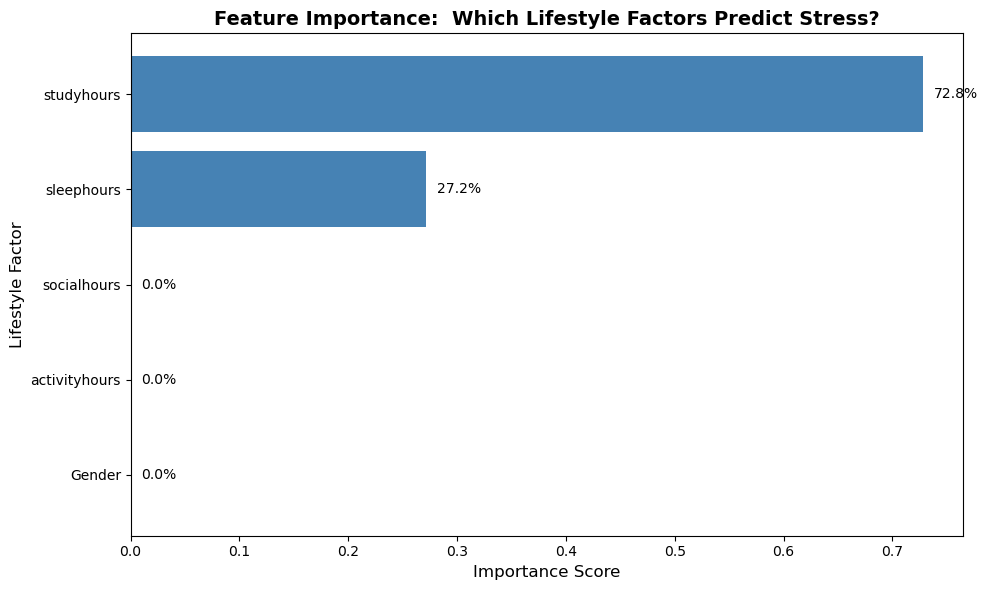

In [11]:
def plot_improved1():
    plt.figure(figsize=(10, 6))
    plt. barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Lifestyle Factor', fontsize=12)
    plt.title('Feature Importance:  Which Lifestyle Factors Predict Stress?', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    for i, (feature, importance) in enumerate(zip(importance_df['Feature'], importance_df['Importance'])):
        plt.text(importance + 0.01, i, f'{importance*100:.1f}%', va='center', fontsize=10)
    plt.tight_layout()
    plt.show()

plot_improved1()

Study hours (72.8%) and sleep hours (27.2%) are the only features the Decision Tree uses.  This explains why PCA didn't dramatically improve results—the tree already ignores irrelevant features through its own feature selection.

---

## Confusion Matrices

In [12]:
# using scaled features for KNN now
y_pred_knn = cross_val_predict(KNeighborsClassifier(n_neighbors=int(best_knn_k)), X_scaled, y, cv=kfold)
y_pred_tree = cross_val_predict(DecisionTreeClassifier(max_depth=best_tree_depth, random_state=42), X, y, cv=kfold)

cm_knn = confusion_matrix(y, y_pred_knn)
cm_tree = confusion_matrix(y, y_pred_tree)

knn_accuracy = cm_knn. trace() / cm_knn.sum() * 100
tree_accuracy = cm_tree.trace() / cm_tree.sum() * 100

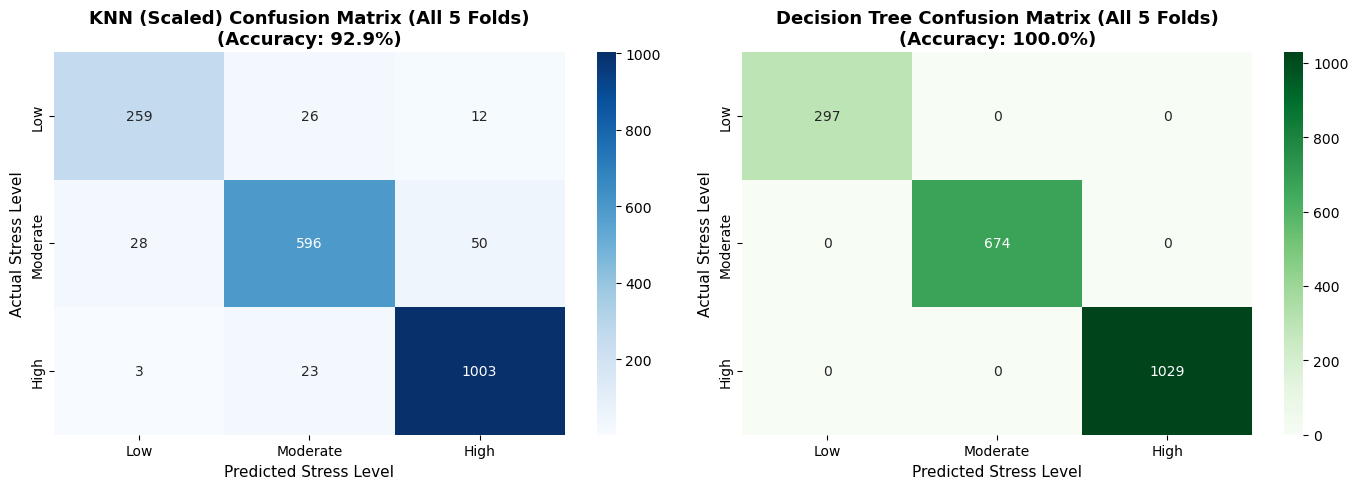

In [13]:
def plot_improved2():
    fig, axes = plt. subplots(1, 2, figsize=(14, 5))
    
    sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Low', 'Moderate', 'High'],
                yticklabels=['Low', 'Moderate', 'High'])
    axes[0]. set_title(f'KNN (Scaled) Confusion Matrix (All 5 Folds)\n(Accuracy: {knn_accuracy:.1f}%)', fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Predicted Stress Level', fontsize=11)
    axes[0].set_ylabel('Actual Stress Level', fontsize=11)
    
    sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=['Low', 'Moderate', 'High'],
                yticklabels=['Low', 'Moderate', 'High'])
    axes[1].set_title(f'Decision Tree Confusion Matrix (All 5 Folds)\n(Accuracy: {tree_accuracy:.1f}%)', fontsize=13, fontweight='bold')
    axes[1]. set_xlabel('Predicted Stress Level', fontsize=11)
    axes[1].set_ylabel('Actual Stress Level', fontsize=11)
    
    plt.tight_layout()
    plt.show()

plot_improved2()

**KNN with scaling:** ~92.9% accuracy, errors mostly between adjacent stress levels. Scaling provides a meaningful 1.1% improvement over raw features (91.8% → 92.9%).

**Decision Tree:** 100% accuracy.  The dataset has clear thresholds that perfectly separate stress categories. Preprocessing (scaling/PCA) cannot improve this result since the tree already achieves perfect separation.

**Why can't preprocessing improve the Decision Tree?** Decision Trees don't rely on distance metrics like KNN does, so scaling has no effect. PCA also cannot help because the tree ignores irrelevant features (social hours, activity hours, gender) through its own feature selection mechanism. Since the model already achieves 100% accuracy by focusing on just study hours and sleep hours, reducing features or rescaling cannot improve beyond perfection.

---